# 1. Importing Libraries and Dataset Setup:


In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import collections
from collections import Counter
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
#https://www.kaggle.com/code/kaop11/sentiment-analyst-pytorch-lstm/notebook
# doesnt learn true meaning of the word because it is an encoder

In [2]:
# Load the training and test datasets
train_df = pd.read_csv('/Users/osbert/Desktop/Programming/train.csv', names=["polarity", "title", "text"])
test_df = pd.read_csv('/Users/osbert/Desktop/Programming/test.csv', names=["polarity", "title", "text"])

# 2. Exploratory Data Analysis


In [3]:
train_df.shape

(3600000, 3)

In [4]:
test_df.shape

(400000, 3)

In [5]:
# Check for missing values in both datasets
print("\nMissing Values in Training Data:")
print(train_df.isnull().sum())

print("\nMissing Values in Test Data:")
print(test_df.isnull().sum())


Missing Values in Training Data:
polarity      0
title       207
text          0
dtype: int64

Missing Values in Test Data:
polarity     0
title       24
text         0
dtype: int64


In [6]:
# Check the number of unique entries in the train and test datasets based on the combination of 'title' and 'text'
train_unique = train_df.drop_duplicates(subset=["title", "text"]).shape[0]
test_unique = test_df.drop_duplicates(subset=["title", "text"]).shape[0]

print(f"Number of unique entries in training data: {train_unique}")
print(f"Number of unique entries in testing data: {test_unique}")

Number of unique entries in training data: 3600000
Number of unique entries in testing data: 400000


In [7]:
# Check data types
print("\nData Types in Training Data:")
print(train_df.dtypes)


Data Types in Training Data:
polarity     int64
title       object
text        object
dtype: object


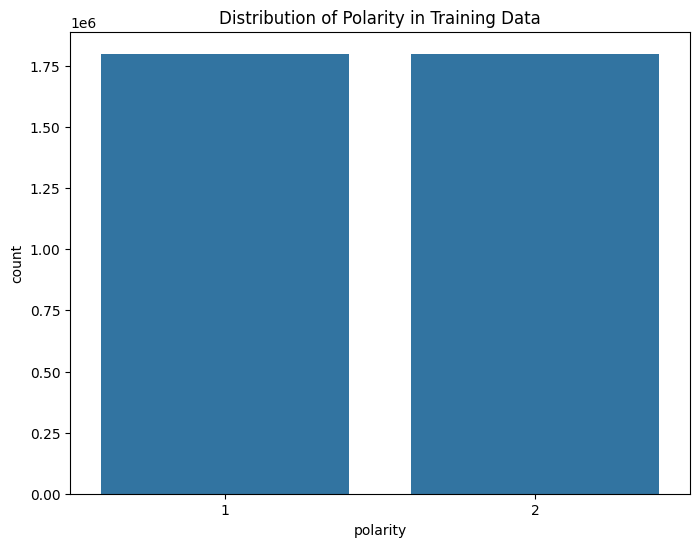

In [8]:
# Check the distribution of the target variable ('polarity')
plt.figure(figsize=(8, 6))
sns.countplot(x='polarity', data=train_df)
plt.title('Distribution of Polarity in Training Data')
plt.show()

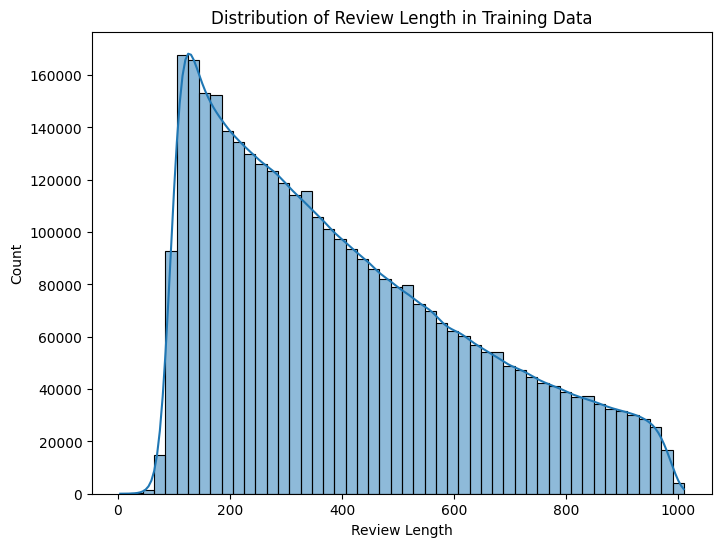

In [33]:
# Check the length of reviews in the text column
train_df['text_length'] = train_df['text'].apply(len)

plt.figure(figsize=(8, 6))
sns.histplot(train_df['text_length'], bins=50, kde=True)
plt.title('Distribution of Review Length in Training Data')
plt.xlabel('Review Length')
plt.show()

# 3. Preprocessing data:


In [6]:
"""
# disabling SSL check
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
"""

nltk.download()

# Download the required corpora
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

# Preload stopwords and lemmatizer
STOPWORDS = set(stopwords.words('english'))


showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>
[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


In [2]:
# remove HTML tag if necessary (done in the Text preprocessing function section)
"""
TAG_RE=re.compile(r'<[^>]+>')
def remove_tag(text):
    "Remove HTML tags: replace anything between opening and closing <> with empty space"
    return TAG_RE.sub("",text)
"""

#replace with white spaces

"""
class CustomPreprocess():
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''

    def __init__(self):
        pass

    def preprocess_text(self,sen):
        sen = sen.lower()
        
        # Remove html tags
        sentence = remove_tags(sen)

        # Remove punctuations and numbers
        sentence = re.sub('[^a-zA-Z]', ' ', sentence)
        
        # Single character removal
        sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

        # Remove multiple spaces
        sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.
        
        # Remove Stopwords
        pattern = re.compile(r'\b(' + r'|'.join(stopwords_list) + r')\b\s*')
        sentence = pattern.sub('', sentence)
        
        return sentence
"""

#Converting positive and negative to ones and zeros (done differently as work shown below)

"""
# Converting sentiment labels to 0 & 1

y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

"""

<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
/var/folders/7p/nnq37v5n39s2jtsql5bdy6br0000gn/T/ipykernel_4296/2061917959.py:11: SyntaxWarning: invalid escape sequence '\s'
  """


'\n# Converting sentiment labels to 0 & 1\n\ny = movie_reviews[\'sentiment\']\n\ny = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))\n\n'

In [8]:
# Combine the 'title' and 'text' columns and fill missing values with an empty string
train_df['text'] = train_df['title'].fillna('') + ' ' + train_df['text'].fillna('')
test_df['text'] = test_df['title'].fillna('') + ' ' + test_df['text'].fillna('')

# Drop the 'title' column 
train_df.drop(columns=['title'], inplace=True)
test_df.drop(columns=['title'], inplace=True)

# Change polarity labels from 1 and 2 to 0 and 1 
""""
1-->0 2-->1
0	"I disliked the movie"
1	"I loved the movie"
"""
train_df['polarity'] = train_df['polarity'].map({1: 0, 2: 1})
test_df['polarity'] = test_df['polarity'].map({1: 0, 2: 1})

In [9]:
train_df.head()

,polarity,text
0,1,Stuning even for the non-gamer This sound trac...
1,1,The best soundtrack ever to anything. I'm read...
2,1,Amazing! This soundtrack is my favorite music ...
3,1,Excellent Soundtrack I truly like this soundtr...
4,1,"Remember, Pull Your Jaw Off The Floor After He..."


N-Gram Analysis 

In Natural Language Processing (NLP), unigrams and bigrams are types of N-grams, which are contiguous sequences of N words or tokens from text. They differ in how many words or tokens are included in each sequence.

In [10]:
#N-Gram Analysis
#Stores the resulting text data for positive reviews as a Pandas Series
positive_reviews = train_df[train_df['polarity'] == 1]['text']
#Stores the resulting text data for negative reviews as a Pandas Series
negative_reviews = train_df[train_df['polarity'] == 0]['text']



1. Unigram Analysis 

A unigram is a single word (or token). It is the simplest form of text representation where each word is treated independently.

"I love programming in Python."

['I', 'love', 'programming', 'in', 'Python']

1. Advantages of Unigrams
- Simple and Computationally Efficient: Easy to implement and process.
- Good for Bag-of-Words Models: Captures individual word frequencies.

2. Limitations of Unigrams
* Lacks Context: Does not capture relationships between words.
- Example: "not good" and "good" are treated as separate, losing the negative connotation in "not good."

Top 10 Positive Unigrams:
       unigram    count
92623     book  1021734
260943   great   833491
256792    good   602341
347765    like   487449
480059    read   407250
322121    just   402319
355035    love   358365
82554     best   321344
591796    time   312032
481012  really   294921

Top 10 Negative Unigrams:
        unigram   count
87543      book  951092
310433     like  546900
289841     just  546548
233111     good  438810
169473      don  394591
527523     time  365294
348799    movie  325550
427732     read  297801
98683       buy  290428
413307  product  283105


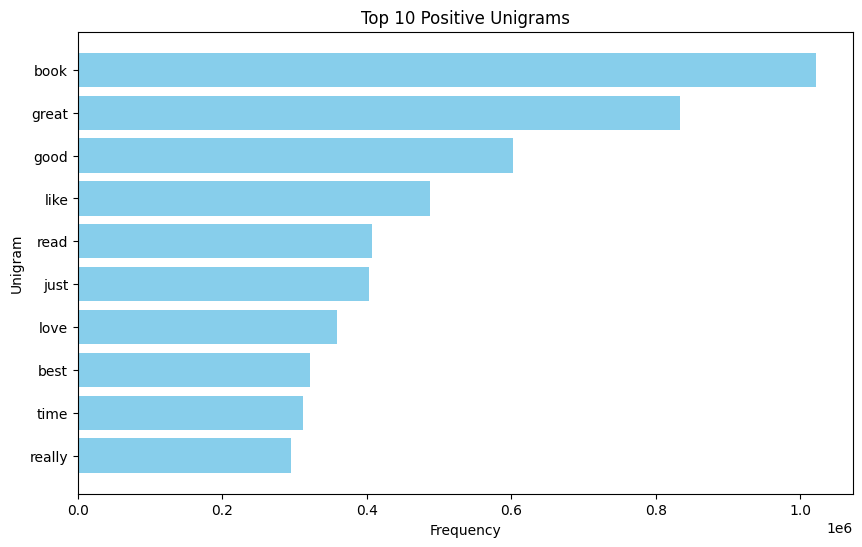

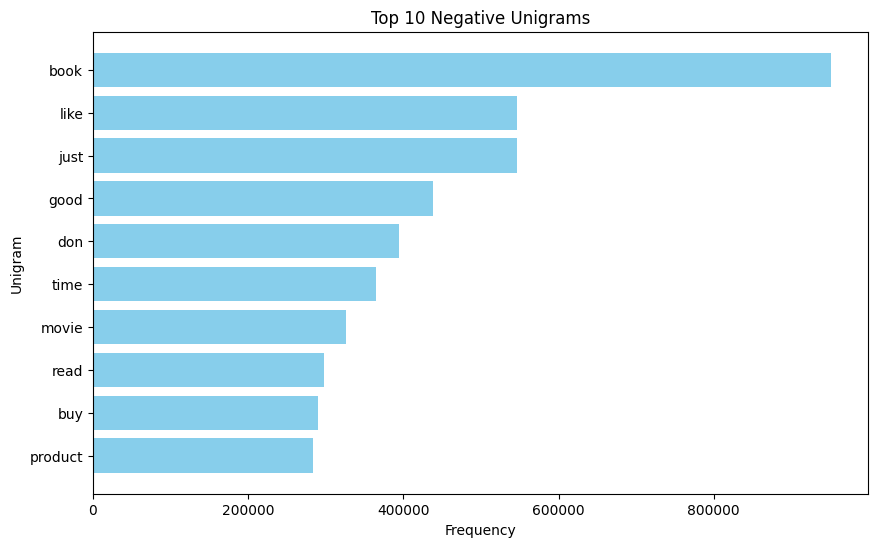

In [39]:
#Unigram Analysis
"""
Perform Unigram Analysis on reviews.
:param reviews: Pandas Series or list of reviews.
:param top_k: Number of top unigrams to return.
:return: DataFrame containing unigrams and their frequencies.
"""
def unigram_analysis(reviews, top_k=10):
    vectorizer = CountVectorizer(stop_words='english')  
    unigram_matrix = vectorizer.fit_transform(reviews)  
    
    # Sum frequencies of each unigram
    unigram_counts = unigram_matrix.sum(axis=0).A1
    unigram_features = vectorizer.get_feature_names_out()
    
    # Create a DataFrame of unigrams and their counts
    unigram_df = pd.DataFrame({'unigram': unigram_features, 'count': unigram_counts})
    unigram_df = unigram_df.sort_values(by='count', ascending=False).head(top_k)
    
    return unigram_df

# Perform Unigram Analysis
positive_unigrams = unigram_analysis(positive_reviews, top_k=10)
negative_unigrams = unigram_analysis(negative_reviews, top_k=10)

print("Top 10 Positive Unigrams:")
print(positive_unigrams)

print("\nTop 10 Negative Unigrams:")
print(negative_unigrams)

def plot_unigrams(unigram_df, title):
    plt.figure(figsize=(10, 6))
    plt.barh(unigram_df['unigram'], unigram_df['count'], color='skyblue')
    plt.xlabel('Frequency')
    plt.ylabel('Unigram')
    plt.title(title)
    plt.gca().invert_yaxis()  
    plt.show()

# Plot Positive Unigrams
plot_unigrams(positive_unigrams, "Top 10 Positive Unigrams")

# Plot Negative Unigrams
plot_unigrams(negative_unigrams, "Top 10 Negative Unigrams")

2. Bigram Analysis 

A bigram is a sequence of two consecutive words. It captures some degree of context by considering word pairs.

"I love programming in Python."

['I love', 'love programming', 'programming in', 'in Python']

1. Advantages of Bigrams
- Preserves Context: Captures relationships between consecutive words, making it more informative.
- Example: "not good" and "very good" are distinct in bigrams.
- Useful for Phrases: Can identify meaningful word combinations (e.g., "machine learning," "New York").

2. Limitations of Bigrams
- Sparsity: Requires more data since the number of possible bigrams grows significantly compared to unigrams.
- Computational Cost: Higher memory and processing requirements than unigrams.
- Lacks Longer Context: Doesn't consider relationships beyond two words.

Top 10 Positive Bigrams:
                    bigram  count
13876458         read book  58734
8139122   highly recommend  52161
7524468         great book  45029
19427401          year old  41151
2054695          book read  29000
19432514         years ago  28388
7381589          good book  28349
7542350      great product  27081
19255919       works great  26911
14056247    recommend book  26086

Top 10 Negative Bigrams:
                    bigram  count
18771777       waste money  89186
18773167        waste time  55083
5159900          don waste  53014
5149928            don buy  45754
13739250         read book  38964
14844245        save money  37451
5154250           don know  35756
19412559          year old  32747
4226311   customer service  26234
5112861         doesn work  24588


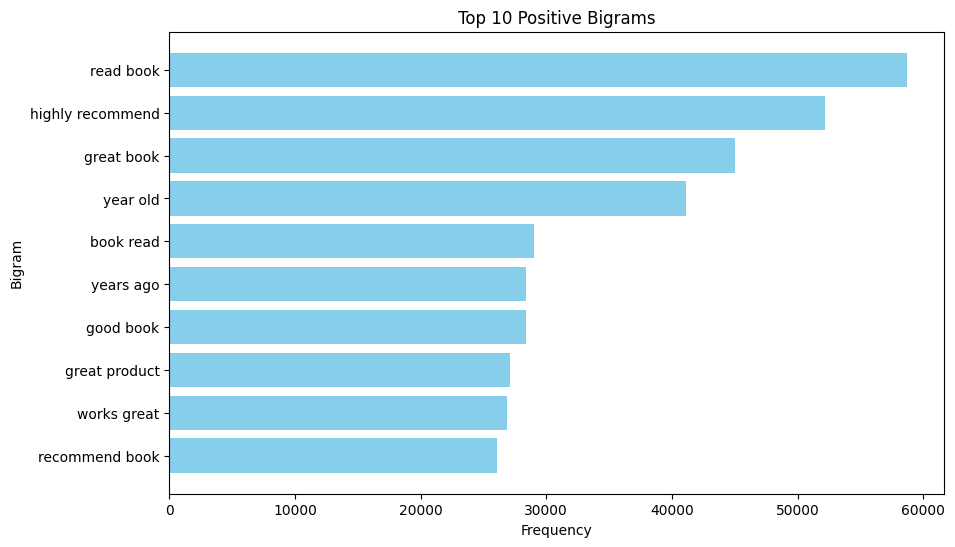

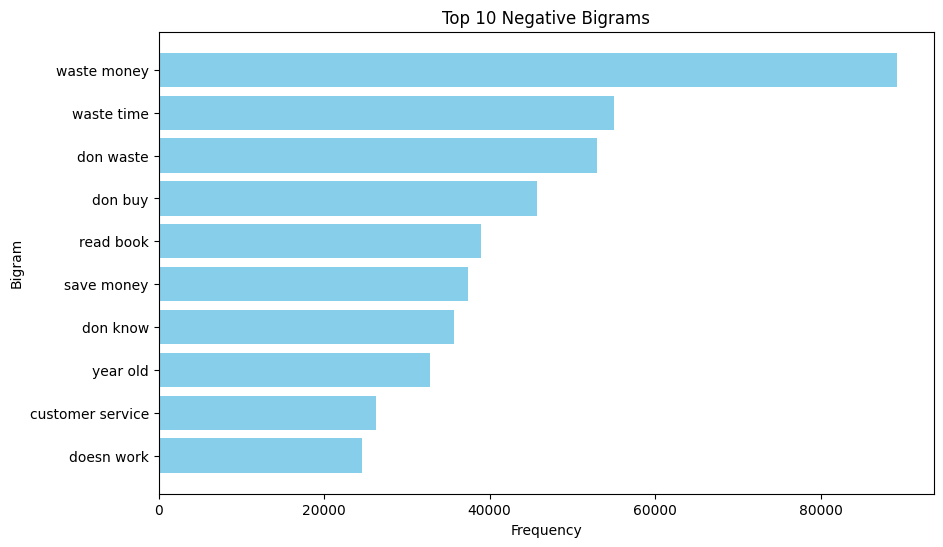

In [11]:
#Bigram Analysis

def bigram_analysis(reviews, top_k=10):
    """
    Perform Bigram Analysis on the reviews.
    :param reviews: Pandas Series or list of reviews.
    :param top_k: Number of most common bigrams to return.
    :return: DataFrame containing the bigrams and their counts.
    """
    # Create a CountVectorizer with ngram_range=(2, 2) to extract bigrams
    vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english') 
    bigram_matrix = vectorizer.fit_transform(reviews)  
    
    # Calculate the frequency of the bigrams
    bigram_counts = bigram_matrix.sum(axis=0).A1
    bigram_features = vectorizer.get_feature_names_out()
    
    # Create a DataFrame with bigrams and their frequencies
    bigram_df = pd.DataFrame({'bigram': bigram_features, 'count': bigram_counts})
    bigram_df = bigram_df.sort_values(by='count', ascending=False).head(top_k)
    
    return bigram_df

# Perform Bigram analysis for positive and negative reviews
positive_bigrams = bigram_analysis(positive_reviews, top_k=10)
negative_bigrams = bigram_analysis(negative_reviews, top_k=10)

# Print the results
print("Top 10 Positive Bigrams:")
print(positive_bigrams)

print("\nTop 10 Negative Bigrams:")
print(negative_bigrams)

def plot_bigrams(bigram_df, title):
    plt.figure(figsize=(10, 6))
    plt.barh(bigram_df['bigram'], bigram_df['count'], color='skyblue')
    plt.xlabel('Frequency')
    plt.ylabel('Bigram')
    plt.title(title)
    plt.gca().invert_yaxis()  
    plt.show()

# Plot Positive Bigrams
plot_bigrams(positive_bigrams, "Top 10 Positive Bigrams")

# Plot Negative Bigrams
plot_bigrams(negative_bigrams, "Top 10 Negative Bigrams")

The bigrams work better than the unigrams, because we can actually see some phrases that really describe what a good sentiment is. Although, in some parts we can still see book objects as the top words, which make us believe that our interpretation about the most selling items are related to book.

1. When to Use Unigrams or Bigrams
- Unigram Use Cases
- When context is not important (e.g., keyword extraction).
- For basic text analysis where individual word frequencies suffice.
2. When working with limited data or computational resources.
- Bigram Use Cases
- When word context or order matters (e.g., sentiment analysis, language modeling).
- For phrase detection or understanding two-word expressions.
- When working with sufficient data to handle increased sparsity.

Text preprocessing

In [41]:
# Text preprocessing function
def preprocess_text(text):
    text = re.sub(r'[^A-Za-zÀ-ú ]+', '', text)#Remove Non-Alphabetic Characters
    #No uppercase or lowercase letter (A-Z, a-z).
    #No Unicode accented character (like á, é, ç, etc., represented by À-ú).
    #No space ( ) 
    text = text.lower()#Convert Text to Lowercase
    tokens = word_tokenize(text) #Splits the text into individual words or tokens
    tokens = [word for word in tokens if word not in STOPWORDS] # Filter out a predefined list of common words like "and," "the," "is," etc., which are not meaningful in many NLP contexts.
    return tokens #returns the cleaned and tokenized list of words
train_df['tokens'] = train_df['text'].apply(preprocess_text) #Applies the preprocess_text function to each entry in the text column
test_df['tokens'] = test_df['text'].apply(preprocess_text)

In [42]:
train_df
test_df

,polarity,text,tokens
0,1,Great CD My lovely Pat has one of the GREAT vo...,"[great, cd, lovely, pat, one, great, voices, g..."
1,1,One of the best game music soundtracks - for a...,"[one, best, game, music, soundtracks, game, di..."
2,0,Batteries died within a year ... I bought this...,"[batteries, died, within, year, bought, charge..."
3,1,"works fine, but Maha Energy is better Check ou...","[works, fine, maha, energy, better, check, mah..."
4,1,Great for the non-audiophile Reviewed quite a ...,"[great, nonaudiophile, reviewed, quite, bit, c..."
...,...,...,...
399995,0,Unbelievable- In a Bad Way We bought this Thom...,"[unbelievable, bad, way, bought, thomas, son, ..."
399996,0,"Almost Great, Until it Broke... My son recieve...","[almost, great, broke, son, recieved, birthday..."
399997,0,Disappointed !!! I bought this toy for my son ...,"[disappointed, bought, toy, son, loves, thomas..."
399998,1,Classic Jessica Mitford This is a compilation ...,"[classic, jessica, mitford, compilation, wide,..."


In [43]:
# Vocabulary building function
# creates a vocabulary, which is a mapping between words (tokens) and their unique numerical indices. 
# It is the foundational step for converting text into numerical representations.
def build_vocab(tokenized_texts, max_vocab_size=10000):
    counter = Counter([token for text in tokenized_texts for token in text]) #Counter counts the occurrences of each token in the flattened list: Counter({'hello': 1, 'world': 1...})
    # Build vocabulary based on the most frequent words
    vocab = {word: idx + 1 for idx, (word, _) in enumerate(counter.most_common(max_vocab_size))} # Output: {'word1': count1, 'word2': count2 (index)}
    vocab['<PAD>'] = 0  #Adds a special token <PAD> to the vocabulary with an index of 0
    vocab['<OOV>'] = len(vocab) #Adds another special token <OOV> ("out of vocabulary") to handle unknown words that are not part of the vocabulary.
    return vocab #Returns the constructed vocabulary as a dictionary
vocab = build_vocab(train_df['tokens']) #Calls build_vocab with the tokenized texts from the train_df['tokens'] column.
print(f"Vocabulary size: {len(vocab)}")

"""
OUTPUT:
{
  'test': 1,
  'hello': 2,
  'world': 3,
  'this': 4,
  'is': 5,
  'a': 6,
  '<PAD>': 0,
  '<OOV>': 7
}
"""

Vocabulary size: 10002


"\nOUTPUT:\n{\n  'test': 1,\n  'hello': 2,\n  'world': 3,\n  'this': 4,\n  'is': 5,\n  'a': 6,\n  '<PAD>': 0,\n  '<OOV>': 7\n}\n"

In [45]:
# Function to encode text into numerical indices
# takes tokenized texts and the vocabulary built in previously 
# convert each token in the text into its corresponding numerical index
def encode_texts(tokenized_texts, vocab):
    return [[vocab.get(token, vocab['<OOV>']) for token in text] for text in tokenized_texts]
#Outer list comprehension: Iterates over each text in tokenized_texts.
#Inner list comprehension: Iterates over each token in the current text.
#vocab.get(token, vocab['<OOV>']):
    #The get method looks up the numerical index of the token in the vocabulary (vocab)
    #If the token is not found in the vocabulary, the get method returns the index of the special <OOV> token. This ensures that unknown words are handled gracefully  

# Encode train and test data using the created vocabulary
#Passes the tokenized texts from the training dataset (train_df['tokens']) and the vocabulary (vocab) to the encode_texts function
train_encoded = encode_texts(train_df['tokens'], vocab)
test_encoded = encode_texts(test_df['tokens'], vocab)

"""
Example
Input:
Training Tokens: [['hello', 'world'], ['this', 'is', 'test']]
Testing Tokens: [['unknown', 'test'], ['this', 'world']]
vocab:
{
    'hello': 1,
    'world': 2,
    'this': 3,
    'is': 4,
    'test': 5,
    '<OOV>': 6
}

Output:
Encoded Training Data: [[1, 2], [3, 4, 5]]
Encoded Testing Data :[[6, 5], [3, 2]]

Unknown Words: Tokens not in vocab are replaced with the index of <OOV>, ensuring the model handles unseen words during training and testing.
Consistency: Both training and testing datasets are encoded using the same vocabulary, ensuring compatibility with downstream tasks.
Applications: Encoded texts can now be used as inputs for machine learning models, such as deep learning models for NLP.
"""

"\nExample\nInput:\nTraining Tokens: [['hello', 'world'], ['this', 'is', 'test']]\nTesting Tokens: [['unknown', 'test'], ['this', 'world']]\nvocab:\n{\n    'hello': 1,\n    'world': 2,\n    'this': 3,\n    'is': 4,\n    'test': 5,\n    '<OOV>': 6\n}\n\nOutput:\nEncoded Training Data: [[1, 2], [3, 4, 5]]\nEncoded Testing Data :[[6, 5], [3, 2]]\n\nUnknown Words: Tokens not in vocab are replaced with the index of <OOV>, ensuring the model handles unseen words during training and testing.\nConsistency: Both training and testing datasets are encoded using the same vocabulary, ensuring compatibility with downstream tasks.\nApplications: Encoded texts can now be used as inputs for machine learning models, such as deep learning models for NLP.\n"

# 4. Data Splitting


In [47]:
# Padding the sequences
# Ensures all sequences have the "same length" by padding shorter sequences or truncating longer ones

def pad_sequences(sequences, max_length, padding_value=0):
    """"
    Creates a 2D NumPy array with dimensions (len(sequences), max_length), where:
    - len(sequences) is the number of sequences in the input 
    - max_length is the fixed length for each sequence

    (All elements are initialized to the value of padding_value (default: 0))
    len(sequences) = 3, max_length = 5, padding_value = 0
    padded_sequences = array([[0, 0, 0, 0, 0],
                           [0, 0, 0, 0, 0],
                           [0, 0, 0, 0, 0]])
    """
    padded_sequences = np.full((len(sequences), max_length), fill_value=padding_value, dtype=int) #padded_sequences[i, :min(len(seq), max_length)] = seq[:max_length]
    for i, seq in enumerate(sequences):#Loops through each sequence in the input list (sequences) and its corresponding index (i)
        padded_sequences[i, :min(len(seq), max_length)] = seq[:max_length]#Copies the values from the original sequence (seq) into the corresponding row (i) of padded_sequences
    return padded_sequences

max_length = 100  # Maximum length for padding
X_train_padded = pad_sequences(train_encoded, max_length)
X_test_padded = pad_sequences(test_encoded, max_length)

#X_train_padded for training
#X_test_padded for testing at prediction

In [ ]:
# Split the training data into training and validation sets
# .values: Extracts the NumPy array of values from the dataframe column

y_train = train_df['polarity'].values
y_test = test_df['polarity'].values

#train_test_split: Split arrays or matrices into random train and test subsets.
X_train, X_val, y_train, y_val = train_test_split(X_train_padded, y_train, test_size=0.2, random_state=42)
# X_train_padded is split into two datasets: X_train, X_val
# y_train is split into two datasets: y_train, y_val

# Convert to PyTorch tensors
#If a GPU is available, it uses cuda for faster computations; otherwise, it defaults to cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Specifies the hardware (CPU or GPU) to use for tensor operations
#torch.tensor: Converts NumPy arrays (X_train, X_val, etc.) into PyTorch tensors for compatibility with PyTorch models.
#dtype=torch.long: Specifies that the data type is 64-bit integers, commonly used for categorical data (e.g., class labels or word indices).
#.to(device): Moves the tensors to the specified device (CPU or GPU).

#dtype=torch.long: Specifies the data type as 64-bit integers, which is commonly used for categorical labels and indices
#.to(device): Moves the tensors to the specified device (GPU or CPU)
X_train_tensor = torch.tensor(X_train, dtype=torch.long).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.long).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)

# Create DataLoader for training and validation sets
batch_size = 32
train_data = TensorDataset(X_train_tensor, y_train_tensor)
val_data = TensorDataset(X_val_tensor, y_val_tensor)


train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
#shuffle=True ensures random sampling for the training set, while validation data remains ordered.
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

print(f"Train loader size: {len(train_loader)}")
print(f"Validation loader size: {len(val_loader)}")

Train loader size: 90000
Validation loader size: 22500


# 5. Defining the Model


The first model is a standard Long Short-Term Memory (LSTM) network designed for sentiment analysis based on text data. Here's a breakdown of its main components:

1. Embedding Layer:
Converts words (tokens) into dense vector representations (embedding vectors), capturing semantic relationships between words.
Implemented using nn.Embedding with the size of the vocabulary (vocabulary_size) and the dimension of the embedding vector (embedding_size).
2. LSTM Layer:
Extracts contextual information from the sequential data and retains long-term dependencies.
Implemented using nn.LSTM with the input size as embedding_size and the hidden layer size as hidden_layer_size.
3. Fully Connected Layer:
Transforms the final hidden state of the LSTM into class probabilities (number_of_classes).
4. Dropout Layer:
Helps prevent overfitting by randomly dropping connections during training.

- Workflow:

1. The input sequence of text is tokenized into word indices (input_sequences).
2. The sequence is passed through the Embedding Layer to obtain embedding vectors.
3. These embeddings are processed by the LSTM Layer to capture sequential dependencies.
4. The last hidden state from the LSTM is passed through the Dropout Layer and then the Fully Connected Layer for classification.

- Advantages:

1. Suitable for sequential data like text.
2. Addresses vanishing gradient issues better than traditional RNNs.
- Limitations:
1. Treats all words in the sequence equally, lacking the ability to focus on key words or phrases.

In [ ]:
# Example
# class Sentiment_LSTMModel(nn.Module):
#     def __init__(self, vocabulary_size, embedding_size, hidden_layer_size, number_of_classes, maximum_sequence_length):
#         super(Sentiment_LSTMModel, self).__init__()
        
#         # Embedding layer
#         self.embedding_layer = nn.Embedding(vocabulary_size, embedding_size, padding_idx=0)
        
#         # LSTM layer
#         self.lstm_layer = nn.LSTM(embedding_size, hidden_layer_size, batch_first=True)
        
#         # Fully connected layer for classification
#         self.classification_layer = nn.Linear(hidden_layer_size, number_of_classes)
        
#         # Dropout layer to reduce overfitting
#         self.dropout_layer = nn.Dropout(0.5)
    
#     def forward(self, input_sequences):
#         # Get the embeddings for the input sequences
#         embedded_input = self.embedding_layer(input_sequences)
        
#         # Pass through the LSTM layer
#         lstm_output, (hidden_state, cell_state) = self.lstm_layer(embedded_input)
        
#         # Get the output from the last hidden state of the LSTM
#         final_hidden_state = hidden_state[-1]
        
#         # Apply dropout and pass through the classification layer
#         dropped_out_hidden_state = self.dropout_layer(final_hidden_state)
#         output_classification = self.classification_layer(dropped_out_hidden_state)
        
#         return output_classification


# # Parameters
# embedding_size = 100   
# hidden_layer_size = 128  
# number_of_classes = 2    
# vocabulary_size = len(vocab)
# maximum_sequence_length = 100   

# # Initialize the model
# model = Sentiment_LSTMModel(
#     vocabulary_size = vocabulary_size,
#     embedding_size = embedding_size,
#     hidden_layer_size = hidden_layer_size,
#     number_of_classes = number_of_classes,
#     maximum_sequence_length = maximum_sequence_length
# ).to(device)

# # Check the model architecture
# print(model)

# loss_function = nn.CrossEntropyLoss()
# optimizer_function = torch.optim.Adam(model.parameters(), lr=0.001)

LSTM with Attention (What we will be using)
- The second model enhances the first by integrating an Attention Mechanism, which helps the model focus on important words or phrases in the text.

1. Embedding Layer:
Same as in the basic LSTM model, transforms tokens into dense vectors.
2. BiLSTM Layer:
A bidirectional LSTM processes the sequence in both forward and backward directions, capturing context from both sides.
Outputs hidden states for both directions, doubling the hidden size.
3. Attention Layer:
Calculates attention scores for each hidden state to determine their importance.
The attention scores are normalized using softmax to generate attention weights.
A weighted sum of the LSTM outputs creates a context vector, which summarizes the sequence while emphasizing important parts.
4. Fully Connected Layer:
Uses the context vector from the attention mechanism to predict the sentiment class.

- Workflow:

1. Input sequences are embedded via the Embedding Layer.
2. The embeddings are processed by the BiLSTM Layer to produce hidden states for each time step in both directions.
3. The Attention Layer assigns importance weights to the hidden states, resulting in a context vector.
4. The context vector is passed through the Dropout Layer and Fully Connected Layer for classification.
- Advantages:

1. Attention enables the model to focus on important parts of the sequence, improving interpretability and performance.
2. BiLSTM captures context from both directions, making it more robust for nuanced text.
- Limitations:

1. Computationally more expensive due to the BiLSTM and attention mechanism.

In [ ]:
import torch.nn.functional as F #used in defining custom layers or mechanisms
# Contains functions to define neural network layers and operations (e.g., softmax, dropout).
# Provides low-level implementations for custom components, like the attention mechanism in this model

#Designed and implemented a custom neural network in PyTorch for sentiment analysis, leveraging a BiLSTM (Bidirectional Long Short-Term Memory) architecture combined with an attention mechanism to classify text sequences.

class Sentiment_LSTM_Attention_Model(nn.Module): #Defines a custom neural network model inheriting from nn.Module, the base class for all PyTorch models
    def __init__(self, vocabulary_size, embedding_size, hidden_layer_size, number_of_classes, maximum_sequence_length): #initializes the model layers and parameters
        super(Sentiment_LSTM_Attention_Model, self).__init__()
        
        # Embedding layer
        self.embedding_layer = nn.Embedding(vocabulary_size, embedding_size, padding_idx=0)
        
        # BiLSTM layer (Bidirectional LSTM)
        self.lstm_layer = nn.LSTM(embedding_size, hidden_layer_size, batch_first=True, bidirectional=True)
        
        # Attention Layer
        self.attention_layer = nn.Linear(hidden_layer_size * 2, 1)  # BiLSTM outputs hidden states for both directions
        
        # Fully connected layer for classification
        self.classification_layer = nn.Linear(hidden_layer_size * 2, number_of_classes)
        
        # Dropout layer to reduce overfitting
        self.dropout_layer = nn.Dropout(0.5)
    
    def attention(self, lstm_output):
        # Apply attention mechanism (Dot-product attention)
        attention_scores = self.attention_layer(lstm_output)  # Calculates attention scores for each time step
        attention_weights = F.softmax(attention_scores, dim=1)  # Converts scores into normalized attention weights across the sequence
        
        # Apply attention weights to the LSTM outputs
        context_vector = torch.sum(attention_weights * lstm_output, dim=1)  # Shape: (batch_size, hidden_size * 2)
        
        return context_vector

    def forward(self, input_sequences):
        # Converts input indices into dense embedding vectors
        embedded_input = self.embedding_layer(input_sequences)
        
        # Pass through the BiLSTM layer ; processes the embeddings to extract sequential patterns
        lstm_output, (hidden_state, cell_state) = self.lstm_layer(embedded_input)
        
        # Apply attention mechanism, computes a context vector focusing on key time steps
        context_vector = self.attention(lstm_output)
        
        # Apply dropout and pass through the classification layer
        dropped_out_hidden_state = self.dropout_layer(context_vector)
        
        # Predicts the class probabilities
        output_classification = self.classification_layer(dropped_out_hidden_state)
        
        return output_classification

# HyperParameters tuning
#To find the best configuration of hyperparameters that allows the model to learn effectively without overfitting or underfitting.
# Parameters
embedding_size = 100   
hidden_layer_size = 128  
number_of_classes = 2    
vocabulary_size = len(vocab)
maximum_sequence_length = 100   


# Initialize the model
model = Sentiment_LSTM_Attention_Model(
    vocabulary_size = vocabulary_size,
    embedding_size = embedding_size,
    hidden_layer_size = hidden_layer_size,
    number_of_classes = number_of_classes,
    maximum_sequence_length = maximum_sequence_length
).to(device)

# Check the model architecture
print(model)

Sentiment_LSTM_Attention_Model(
  (embedding_layer): Embedding(10002, 100, padding_idx=0)
  (lstm_layer): LSTM(100, 128, batch_first=True, bidirectional=True)
  (attention_layer): Linear(in_features=256, out_features=1, bias=True)
  (classification_layer): Linear(in_features=256, out_features=2, bias=True)
  (dropout_layer): Dropout(p=0.5, inplace=False)
)


In [54]:
# loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer_function = optim.Adam(model.parameters(), lr=0.001)

# 6. Training Setup and Evaluation


Training Workflow:
- Forward Pass:
Pass input data through the model to get predictions (logits).
- Compute Loss:
Use loss_function(predictions, true_labels) to compute the error.
- Backward Pass:
Compute gradients of the loss with respect to model parameters using loss.backward().
- Optimization Step:
Update model parameters using optimizer_function.step().

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

# Define loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer_function = optim.Adam(model.parameters(), lr=0.001)

# Define the training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    best_val_loss = float('inf')  # Store the best validation loss value
    
    # To store the results for plotting later
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        start_time = time.time()  # Record the start time of the epoch
        
        model.train()  
        train_loss = 0
        correct_preds = 0
        total_preds = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Perform optimization
            optimizer.zero_grad()  
            outputs = model(inputs)  
            
            # Calculate loss and perform backward pass
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Update results
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)
        
        train_accuracy = 100 * correct_preds / total_preds
        train_loss /= len(train_loader)
        
        # Save the results for plotting
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Evaluate on the validation set
        model.eval()
        val_loss = 0
        val_correct_preds = 0
        val_total_preds = 0
        
        with torch.no_grad():  # Disable gradient calculation during evaluation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                val_correct_preds += (predicted == labels).sum().item()
                val_total_preds += labels.size(0)
        
        val_accuracy = 100 * val_correct_preds / val_total_preds
        val_loss /= len(val_loader)
        
        # Save the results for plotting
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        # Timer for the epoch
        epoch_time = time.time() - start_time  # Calculate time taken for the epoch
        remaining_time = epoch_time * (num_epochs - (epoch + 1))  # Estimate remaining time
        
        # Print results for each epoch
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, "
              f"Time: {epoch_time:.2f}s, Remaining Time: {remaining_time/60:.2f} minutes")
        
        # Save the model if the validation loss decreases
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_lstm_model.pth') 
    
    # Return the lists to plot later
    return train_losses, val_losses, train_accuracies, val_accuracies

# Train the model and get the metrics for plotting
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, loss_function, optimizer_function, num_epochs=5
)


Epoch 1/5, Train Loss: 0.2034, Train Accuracy: 91.91%, Val Loss: 0.1926, Val Accuracy: 92.32%, Time: 6732.02s, Remaining Time: 448.80 minutes
Epoch 2/5, Train Loss: 0.1876, Train Accuracy: 92.63%, Val Loss: 0.1906, Val Accuracy: 92.43%, Time: 6669.51s, Remaining Time: 333.48 minutes
Epoch 3/5, Train Loss: 0.1807, Train Accuracy: 92.94%, Val Loss: 0.1899, Val Accuracy: 92.53%, Time: 13226.62s, Remaining Time: 440.89 minutes
Epoch 4/5, Train Loss: 0.1776, Train Accuracy: 93.08%, Val Loss: 0.1912, Val Accuracy: 92.45%, Time: 5735.58s, Remaining Time: 95.59 minutes
Epoch 5/5, Train Loss: 0.1763, Train Accuracy: 93.12%, Val Loss: 0.1893, Val Accuracy: 92.51%, Time: 6100.15s, Remaining Time: 0.00 minutes


In [ ]:
"""
original code without remaining timer
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    best_val_loss = float('inf')  # Store the best validation loss value
    
    # To store the results for plotting later
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()  
        train_loss = 0
        correct_preds = 0
        total_preds = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Perform optimization
            optimizer.zero_grad()  
            outputs = model(inputs)  
            
            # Calculate loss and perform backward pass
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Update results
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)
        
        train_accuracy = 100 * correct_preds / total_preds
        train_loss /= len(train_loader)
        
        # Save the results for plotting
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Evaluate on the validation set
        model.eval()
        val_loss = 0
        val_correct_preds = 0
        val_total_preds = 0
        
        with torch.no_grad():  # Disable gradient calculation during evaluation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                val_correct_preds += (predicted == labels).sum().item()
                val_total_preds += labels.size(0)
        
        val_accuracy = 100 * val_correct_preds / val_total_preds
        val_loss /= len(val_loader)
        
        # Save the results for plotting
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        # Print results for each epoch
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
        
        # Save the model if the validation loss decreases
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_lstm_model.pth') 
    
    # Return the lists to plot later
    return train_losses, val_losses, train_accuracies, val_accuracies

# Train the model and get the metrics for plotting
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, loss_function, optimizer_function, num_epochs= 5)
"""

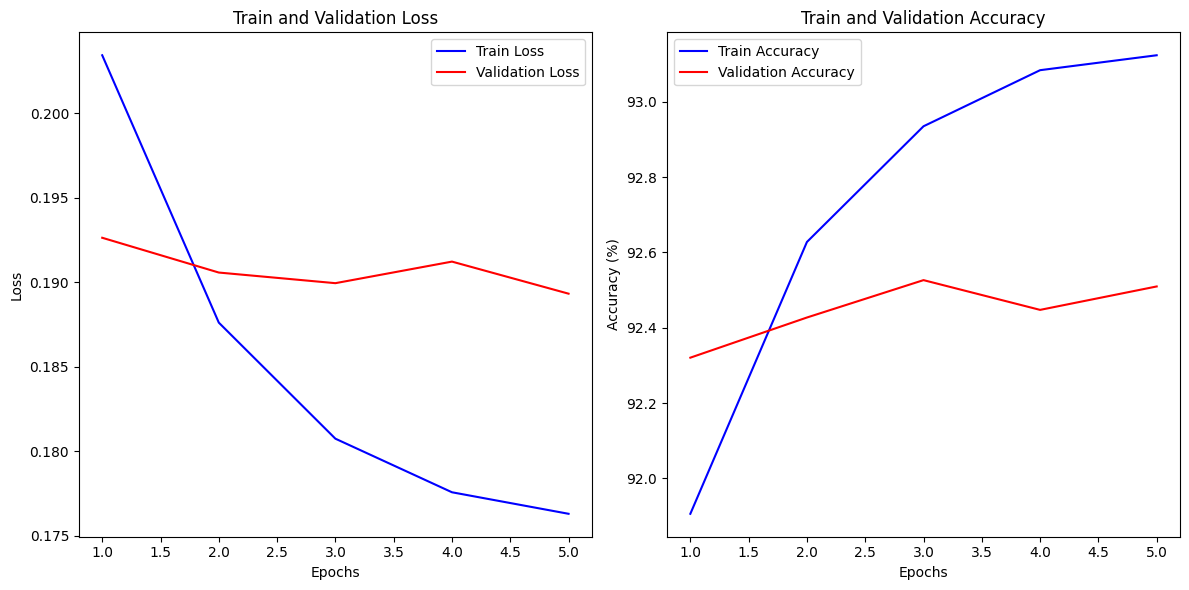

In [59]:
# Plot training and validation losses
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Train and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# 7. Prediction and Evaluation on test data

In [60]:
# Predict on the test set 
def predict(model, test_loader):
    model.eval()  
    predictions = []
    
    with torch.no_grad():  
        for inputs in test_loader:  
            inputs = inputs[0].to(device) 
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy()) 
    return predictions

# Convert test data into DataLoader
test_data = TensorDataset(torch.tensor(X_test_padded, dtype=torch.long).to(device),
                           torch.tensor(y_test, dtype=torch.long).to(device)) 
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Get predictions for the test set
test_predictions = predict(model, test_loader)

Accuracy: 0.9239
Precision: 0.9251
Recall: 0.9224
F1-Score: 0.9237
Confusion Matrix:
[[185053  14947]
 [ 15511 184489]]


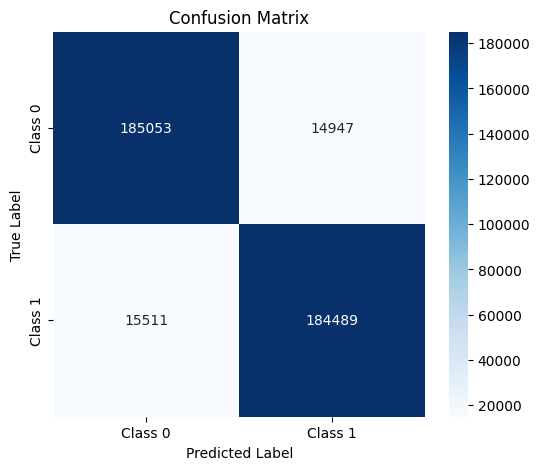

In [61]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, test_predictions)
precision = precision_score(y_test, test_predictions)
recall = recall_score(y_test, test_predictions)
f1 = f1_score(y_test, test_predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

AUC-ROC: 0.9775


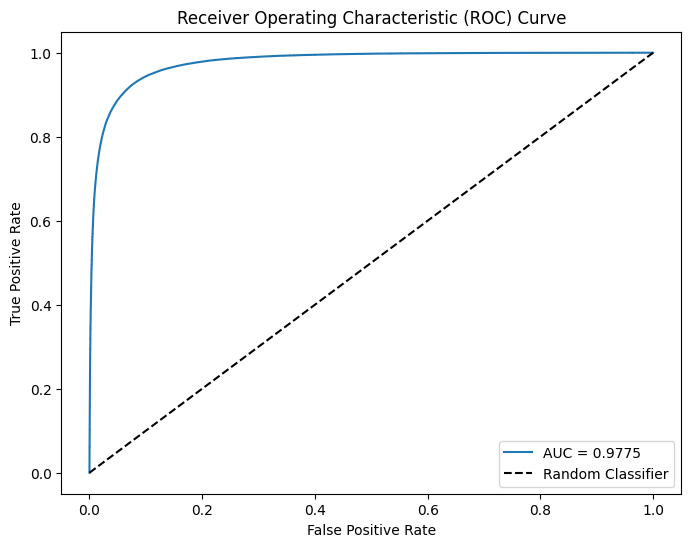

In [62]:
# Function to get probabilities for AUC-ROC
def predict_proba(model, test_loader):
    model.eval()  
    pred_probs = []  
    true_labels = []  
    
    with torch.no_grad():  
        for inputs, labels in test_loader:  
            inputs, labels = inputs.to(device), labels.to(device) 
            outputs = model(inputs)  
            
            # Apply softmax to get probabilities
            probs = torch.sigmoid(outputs).squeeze()  # binary classification
            pred_probs.append(probs.cpu().numpy()) 
            true_labels.append(labels.cpu().numpy()) 
    
    # Concatenate the probabilities and labels for further processing
    pred_probs = np.concatenate(pred_probs, axis=0)
    true_labels = np.concatenate(true_labels, axis=0)
    
    return pred_probs, true_labels

# Function to plot the AUC-ROC curve
def plot_auc_roc(model, test_loader):
    # Get predicted probabilities and true labels
    pred_probs, true_labels = predict_proba(model, test_loader)
    
    # Calculate AUC-ROC score (for binary classification, use [:, 1] for positive class)
    auc_roc = roc_auc_score(true_labels, pred_probs[:, 1])  # For binary classification, get probabilities for class 1
    print(f"AUC-ROC: {auc_roc:.4f}")
    
    # Plot the ROC curve
    fpr, tpr, thresholds = roc_curve(true_labels, pred_probs[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc_roc:.4f}")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Convert test data into DataLoader
test_data = TensorDataset(torch.tensor(X_test_padded, dtype=torch.long).to(device),
                           torch.tensor(y_test, dtype=torch.long).to(device)) 
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Call the function to plot AUC-ROC
plot_auc_roc(model, test_loader)

Key Metric: AUC-ROC
- AUC-ROC is the most important metric because:

1. It evaluates the model's ability to distinguish between classes across all thresholds.
2. It is independent of a specific classification threshold.
3.  It performs well in imbalanced datasets by providing a more holistic view of the model's performance.
- Comparison to Other Metrics:
1. Accuracy: Measures the percentage of correct predictions (both positives and negatives). It can be misleading in imbalanced datasets.
2. Precision: Measures how many of the predicted positives are actually positive. It is focused on minimizing false positives.
3. Recall: Measures how many of the actual positives were correctly identified by the model. It is focused on minimizing false negatives.
4. F1-Score: A harmonic mean of Precision and Recall, balancing the two metrics when there’s a trade-off between them.


# 8. Error Analysis

In [63]:
# Identify misclassified samples
misclassified_idx = [i for i in range(len(y_test)) if y_test[i] != test_predictions[i]]

# Extract misclassified data
misclassified_texts = [test_df['text'][i] for i in misclassified_idx]
misclassified_labels = [y_test[i] for i in misclassified_idx]
misclassified_preds = [test_predictions[i] for i in misclassified_idx]

# Analyze text lengths of misclassified samples
misclassified_lengths = [len(text.split()) for text in misclassified_texts]
print(f"Average length of misclassified samples: {np.mean(misclassified_lengths):.2f}")

# Example: Investigate specific patterns in misclassified samples
print("Examples of misclassified texts:")
for i in range(5):
    print(f"Text: {misclassified_texts[i]}")
    print(f"True Label: {misclassified_labels[i]}, Predicted Label: {misclassified_preds[i]}")
    print("---")

Average length of misclassified samples: 79.15
Examples of misclassified texts:
Text: SOY UN APASIONADO DEL BOX Y ESTE LIBRO ESTÁ ESPLÉNDIDO !Lo disfrutas, lo puedes usar como obra de consultaNos trae LAS HISTORIA DE LOS BOXEADORES MÁS BRILLANTES, DE LOS CAMPEONES DURANTE CIEN AÑOS !!Si te gusta el box...¡NO TE LO PIERDAS !
True Label: 1, Predicted Label: 0
---
Text: They'd watch it nonstop if I'd let them apart from it arriving broken the first time, my kids are loving this DVD, which I alternate with the other I purchased to keep my own sanity. This DVD has created a Thomas fan out of my 3 1/2 yr. old daughter as well.
True Label: 1, Predicted Label: 0
---
Text: Amazing... love it...very touch.it's to bad that in the dvd description doesn't mention no subtitles
True Label: 1, Predicted Label: 0
---
Text: Patricia Cornwell has turned me into a reader I was never really a big reader before and somebody put me on to Patricia Cornwell. Well, now I can't put her books down. Her books just

Misclassification Analysis
- The average length of misclassified samples is 79.29.

Misclassified Texts and Reasons:
1. Text: "Not an 'ultimate guide'... clarify the requirements for you."
- True Label: 0 (Negative)
- Predicted Label: 1 (Positive)
- Reason: The text starts with a negative critique ("Not an 'ultimate guide'") but ends with a positive note. The model fails to properly capture the mixed sentiment and incorrectly classifies it as positive.
2. Text: "Amazing... love it... very touch. It's too bad that in the DVD description it doesn't mention no subtitles."
- True Label: 1 (Positive)
- Predicted Label: 0 (Negative)
- Reason: The text includes a positive sentiment ("love it"), but the model misinterprets the negative complaint about the lack of subtitles, resulting in an incorrect negative classification.
3. Text: "Patricia Cornwell has turned me into a reader... I highly recommend reading not just this book but the entire Kay Scarpetta series."
- True Label: 1 (Positive)
- Predicted Label: 0 (Negative)
- Reason: Despite the strong positive sentiment and recommendation, the model mistakenly classifies the review as negative due to focusing on certain negative aspects.
4. Text: "Had to return it... Squeem makes a vest version too so maybe that one will be a better choice."
- True Label: 0 (Negative)
- Predicted Label: 1 (Positive)
- Reason: The model misinterprets the frustration with the sizing and discomfort as a positive experience because the reviewer provides a potential solution in the end.
5. Text: "I recommend ordering a size or 2 larger than your regular size... the quality of the product is exceptionally well stitched."
- True Label: 1 (Positive)
- Predicted Label: 0 (Negative)
- Reason: The model misses the overall positive sentiment, especially regarding the product quality, and incorrectly focuses on the sizing issue, leading to a negative classification.

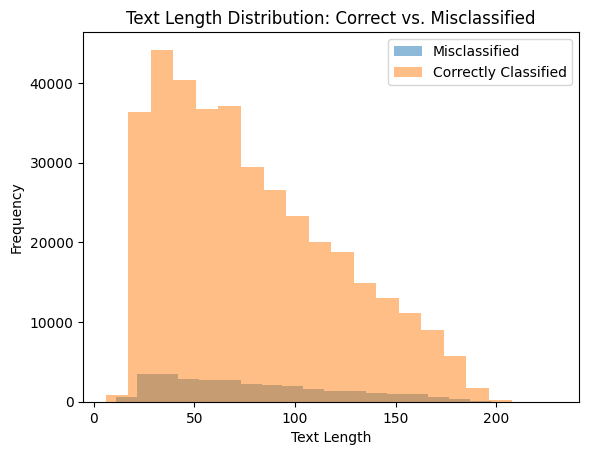

In [64]:
# Analyze text length distribution
correct_idx = [i for i in range(len(y_test)) if y_test[i] == test_predictions[i]]
correct_lengths = [len(test_df['text'][i].split()) for i in correct_idx]

plt.hist(misclassified_lengths, bins=20, alpha=0.5, label="Misclassified")
plt.hist(correct_lengths, bins=20, alpha=0.5, label="Correctly Classified")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.legend()
plt.title("Text Length Distribution: Correct vs. Misclassified")
plt.show()

## Error Analysis: Text Length Distribution and Misclassification
### 1. Text Length Distribution
Correctly Classified Samples:
- Majority are short texts, with a peak at the 0-50 token range.
- Distribution spreads across various text lengths, suggesting the model is able to classify longer texts well.


Misclassified Samples:
- Misclassifications are concentrated in shorter text lengths (0-50 tokens).
- Misclassified samples have a lower frequency than correctly classified samples in the same range.
### 2. Key Insights
- Short Texts and Misclassification: Short texts are more likely to be misclassified. The model may struggle due to the lack of context and fewer features available in short texts.
- Longer Texts: The model performs better on longer texts, where it can capture more context and avoid irrelevant features.

## Next project
### The code combines LSTM with a simplified attention mechanism for sentiment analysis, which is a hybrid approach.
### To implement the "Attention Is All You Need" paper, you would need to:
#### Replace the LSTM with a Transformer Encoder.
#### Use multi-head self-attention for capturing dependencies across the input sequence.
#### Include positional encoding for sequence order information.